In [2]:
import keras.backend as K
import numpy as np
from matplotlib import pyplot as plt

def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print('shape为',layer_activations.shape)
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network    should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    """
    Suppose input_dim = 10  time_steps = 6
    formed one  x 6 x 10 The data of each step 6 dimension is the same as y
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:,:,attention_dim] =  np.tile(y[:], (1, time_steps))


    return x,y
     

In [4]:
from keras.layers import Input, Dense, LSTM ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model

#from attention_utils import get_activations

from keras.layers.core import *
from keras.models import *

import  pandas as pd
import  numpy as np

from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Reshape
 

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul



def create_dataset(dataset:pd.DataFrame, look_back:int):
    '''
    Processing the data
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back),1:]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y



def attention_model():
    # inputs = Input(((data.shape[1],1)))
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters = 64,kernel_size =32,dilation_rate=2,padding="same", activation="relu")(inputs)
    # x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(drop)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #For GPU you can use CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True,name='bilstm'))(x)
    lstm_out = Dropout(drop)(lstm_out)

    #attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(lstm_out)

    #output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model
     

ModuleNotFoundError: No module named 'keras.layers.core'

In [ ]:
import  pandas as pd
dfstate = pd.read_csv("./data/states.txt")
dfstate["start"] = dfstate.apply(
    lambda row: row["date"] + " " + row["start_time"], axis=1
)
dfstate["end"] = dfstate.apply(lambda row: row["date"] + " " + row["end_time"], axis=1)
dfstate["label"] = dfstate.pop("state").str.strip()
# 转为时间类型
dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
# dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
# dfstate['label'] = dfstate.apply(number_to_label,axis=1)
dfstate.to_csv("./data/states.csv")
dfstate.head(), dfstate.shape
 

(         date start_time  end_time               start                 end  \
 0  2023-12-17   10:44:49  10:48:59 2023-12-17 10:44:49 2023-12-17 10:48:59   
 1  2023-12-17   11:29:45  11:31:55 2023-12-17 11:29:45 2023-12-17 11:31:55   
 2  2023-12-17   12:23:56  12:29:44 2023-12-17 12:23:56 2023-12-17 12:29:44   
 3  2023-12-17   12:55:08  12:56:28 2023-12-17 12:55:08 2023-12-17 12:56:28   
 4  2023-12-17   13:45:02  13:45:42 2023-12-17 13:45:02 2023-12-17 13:45:42   
 
   label  
 0     装  
 1     卸  
 2     装  
 3     卸  
 4     装  ,
 (56, 6))

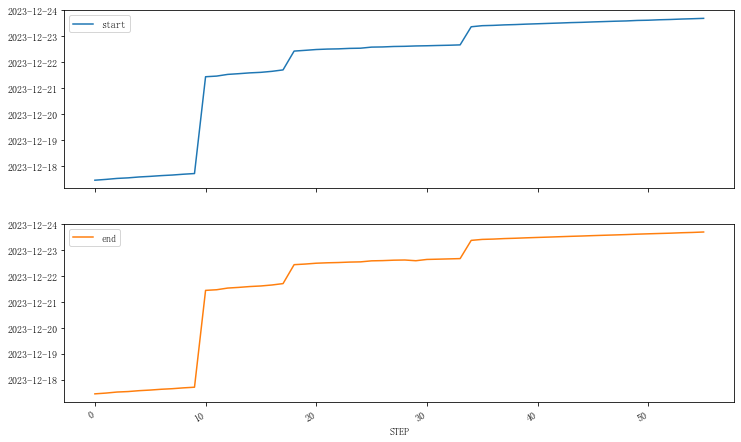

In [ ]:
dfstate.plot(legend=True, subplots=True, figsize=(12,8), xlabel="STEP")
plt.show()

In [ ]:
# 定义读取，处理数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果

    inputDF.insert(0, "label", "-")

    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]

        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass

    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF


def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(
        pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"])
    )


# 读取数据
df17 = read_data("./data/data_17.xlsx")
df21 = read_data("./data/data_21.xlsx")
df22 = read_data("./data/data_22.xlsx")
df23 = read_data("./data/data_23.xlsx")


In [ ]:

data =  df17.drop([ "轨迹时间"], axis = 1)
number_types = [np.number]
label_types = ["object"]
time_types = ["datetime64[ns]"]
numeric_cols = data.select_dtypes(include=number_types).columns.tolist()
label_cols = data.select_dtypes(include=label_types).columns.tolist()
time_cols = data.select_dtypes(include=time_types).columns.tolist()
print(numeric_cols,label_cols,time_cols)
print(data.columns)
print(data.shape)

['原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff', 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff', 'su_y_diff', 'su_z_diff', '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶'] ['label'] ['时间']
Index(['label', '时间', '原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z',
       'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff',
       'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff',
       'su_y_diff', 'su_z_diff', '速度', '估计重量', '原始重量加速度', '稳定重量加速度',
       '原始重量加速度_二阶', '稳定重量加速度_二阶'],
      dtype='object')
(16530, 28)


g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


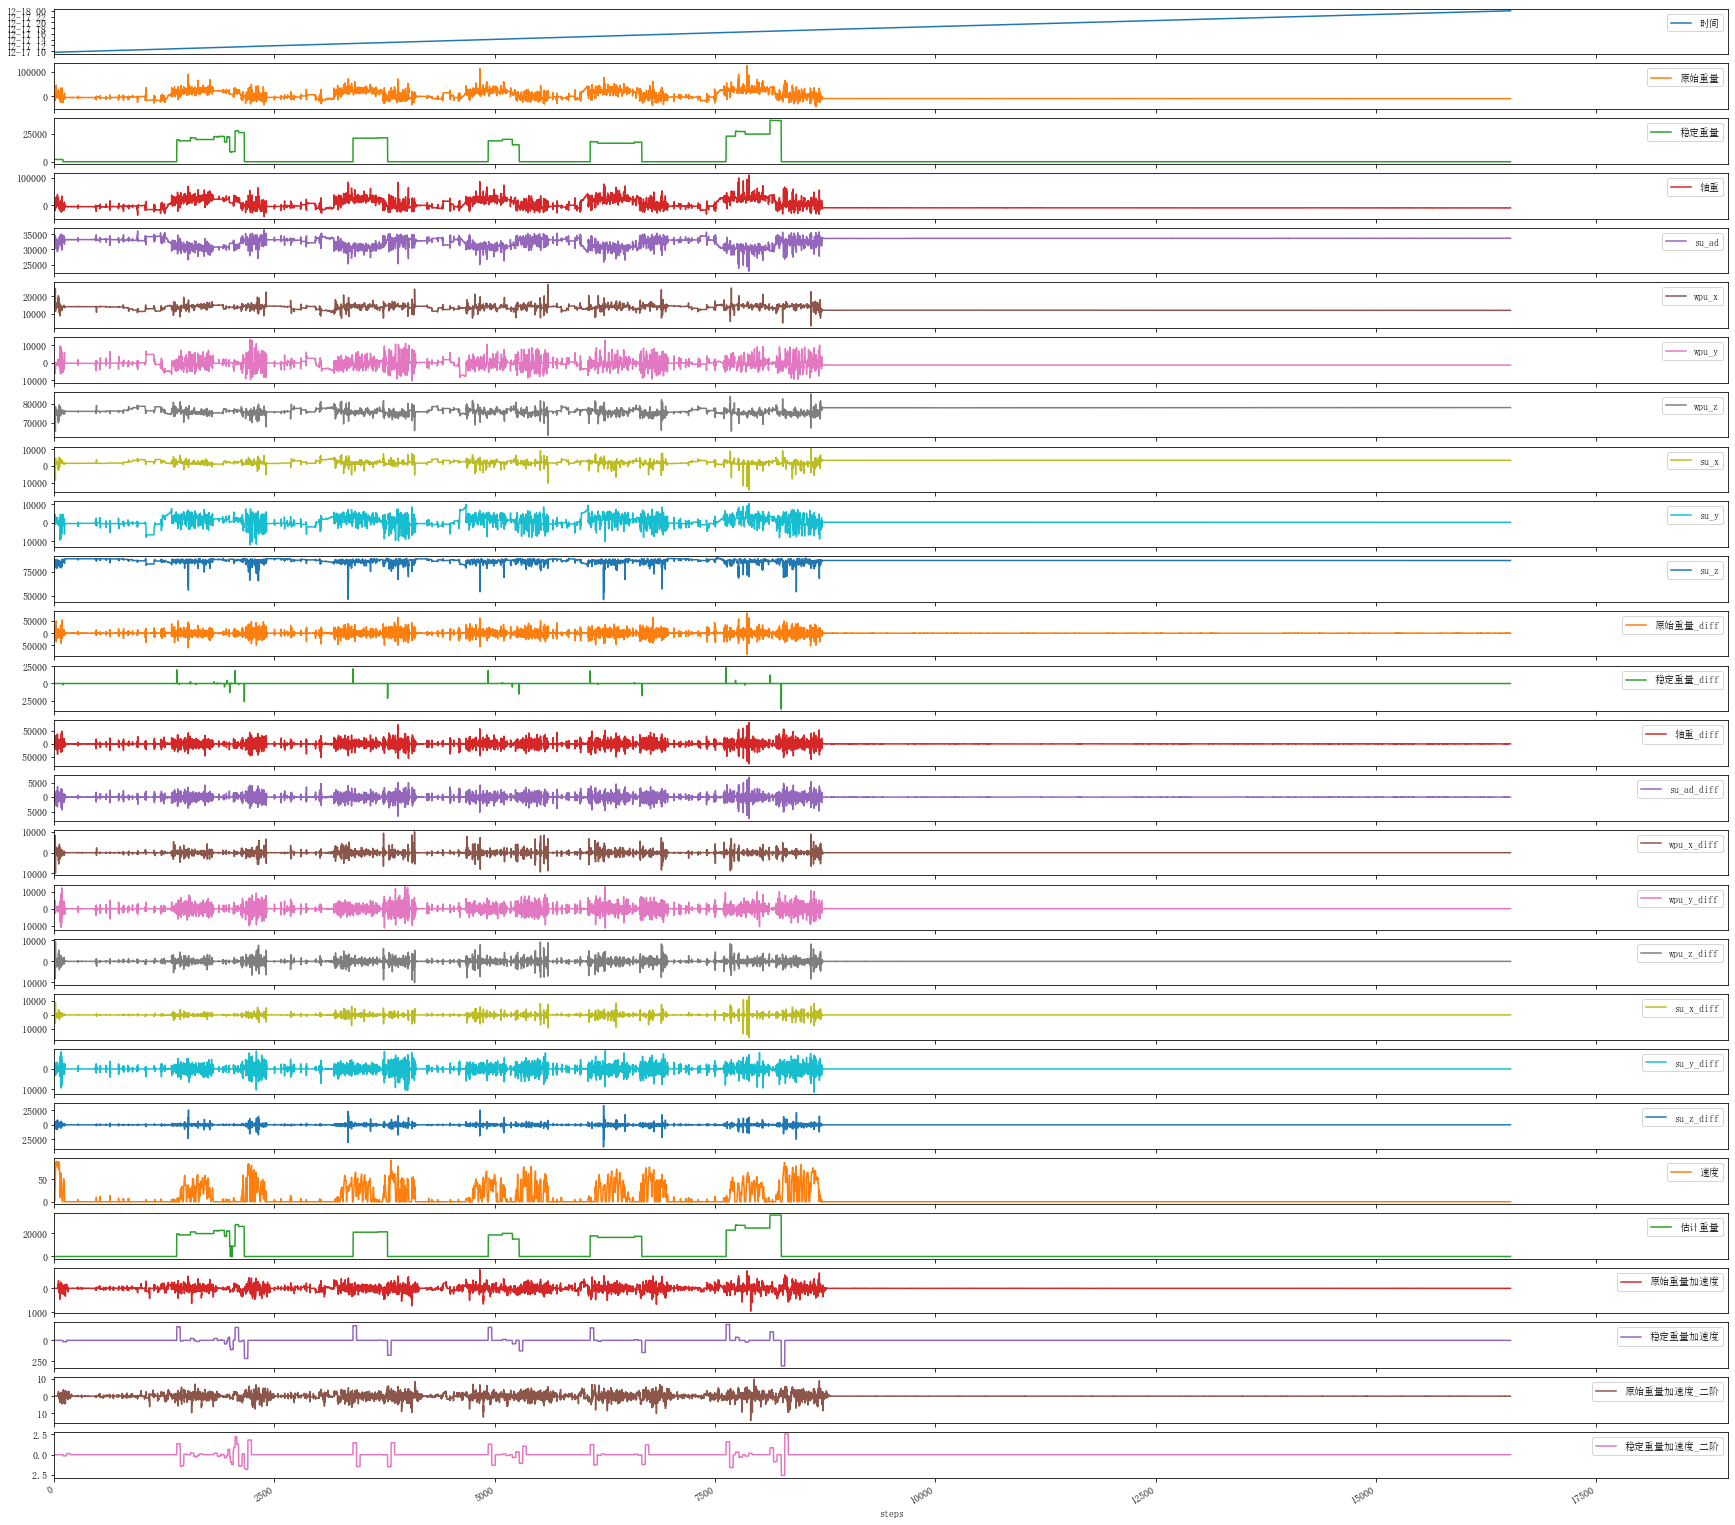

In [ ]:


data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
ax = plt.gca()
ax.set_xlim(left=0, right=19000)

# 或者直接指定字体文件路径
plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN'] 

# plt.show()


### 改各自层数！

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler


# Multidimensional normalization returns data and maximum and minimum values
def NormalizeMult(data:pd.DataFrame):
    #normalize Used for denormalization
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    print(normalize.shape)
    for i in range(0,data.shape[1]):
        #Column i
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

# Multidimensional denormalization
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data


display(len(numeric_cols)+ len(time_cols))
display(label_cols,time_cols,numeric_cols)

from typing import Tuple

def normalize(inpudf: pd.DataFrame,numeric_cols:list,label_cols:list,time_cols:list) -> Tuple[pd.DataFrame , StandardScaler,LabelEncoder]:

    # 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
    # 创建标准化器对象
    scaler = StandardScaler()
    scaler.fit(inpudf[numeric_cols])

    # （label）标准化
    le = LabelEncoder()
    #["装", "卸",'-']
    le.fit(inpudf[label_cols])

    # newdata=np.array(inpudf)
    # 数值型数据标准化： 使用StandardScaler或者MinMaxScaler进行标准化处理。
    for col in numeric_cols:
        inpudf[col] = le.fit_transform(inpudf[col])

    # 类别数据（label）标准化： 类别数据通常不做标准化，而是进行编码，比如One-Hot编码或者Label Encoding。
    for col in label_cols:
        inpudf[col] = le.fit_transform(inpudf[col])
    # 时间数据标准化： 时间数据通常不进行标准化，而是转换成可以比较的形式，如Unix时间戳或时间段差。
    # 将所有时间列转换为Unix时间戳（单位为秒）
    for col in time_cols:
        inpudf[col] = (
            inpudf[col].astype(np.int64) / 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf,scaler,le


# 反标准化


def denormalize(inpudf: pd.DataFrame,scaler:StandardScaler,le:LabelEncoder) -> pd.DataFrame:
    """对df中的数值列进行反标准化处理"""

    # 数值型数据标准化-
    inpudf[numeric_cols] = scaler.inverse_transform(inpudf[numeric_cols])

    # 类别数据（label）标准化-
    for col in label_cols:
        inpudf[col] = le.inverse_transform(inpudf[col])

    # 时间数据标准化-
    for col in time_cols:
        inpudf[col] = pd.to_datetime(
            inpudf[col] * 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf 

27

['label']

['时间']

['原始重量',
 '稳定重量',
 '轴重',
 'su_ad',
 'wpu_x',
 'wpu_y',
 'wpu_z',
 'su_x',
 'su_y',
 'su_z',
 '原始重量_diff',
 '稳定重量_diff',
 '轴重_diff',
 'su_ad_diff',
 'wpu_x_diff',
 'wpu_y_diff',
 'wpu_z_diff',
 'su_x_diff',
 'su_y_diff',
 'su_z_diff',
 '速度',
 '估计重量',
 '原始重量加速度',
 '稳定重量加速度',
 '原始重量加速度_二阶',
 '稳定重量加速度_二阶']

In [ ]:
data.head()

,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,wpu_z_diff,su_x_diff,su_y_diff,su_z_diff,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,-,2023-12-17 09:39:23,-4063,2020,-4375,33161,13662,326,76328,1867,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,-,2023-12-17 09:39:26,-4175,2020,-4364,33160,13636,327,76355,1867,...,27,0,0,0,0,0,0.0,0.0,0.0,0.0
2,-,2023-12-17 09:39:30,-4575,2020,-4486,33171,13649,312,76342,1867,...,-13,0,5,5,0,0,0.0,0.0,0.0,0.0
3,-,2023-12-17 09:39:32,-4330,2020,-4397,33163,13649,314,76342,1867,...,0,0,6,6,0,0,0.0,0.0,0.0,0.0
4,-,2023-12-17 09:39:35,-4442,2020,-4475,33170,13648,314,76343,1873,...,1,6,-6,-11,0,0,0.0,0.0,0.0,0.0


In [ ]:

INPUT_DIMS = len(numeric_cols)+ len(time_cols)
TIME_STEPS = 50
lstm_units = 64
drop = 0
numeric_cols = ['原始重量', '稳定重量', '轴重', 'su_ad', 
                'wpu_x', 'wpu_y', 'wpu_z', 
                'su_x', 'su_y', 'su_z', 
                '原始重量_diff', '稳定重量_diff', '轴重_diff', 
                'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff',
                'su_x_diff', 'su_y_diff', 'su_z_diff', 
                '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶'] 
label_cols = ['label']
time_cols = ['时间']
#Normalized
data,scaler,le = normalize(data,numeric_cols,label_cols,time_cols)
data.head()


g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,wpu_z_diff,su_x_diff,su_y_diff,su_z_diff,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,0,1.702806e+09,1303,1,963,2906,1720,2910,2136,426,...,1264,609,1080,869,0,0,2974,91,4089,183
1,0,1.702806e+09,1291,1,964,2905,1694,2911,2163,426,...,1291,609,1080,869,0,0,2974,91,4089,183
2,0,1.702806e+09,1237,1,953,2916,1707,2898,2150,426,...,1251,609,1081,870,0,0,2974,91,4089,183
3,0,1.702806e+09,1270,1,961,2908,1707,2900,2150,426,...,1264,609,1082,871,0,0,2974,91,4089,183
4,0,1.702806e+09,1256,1,954,2915,1706,2900,2151,427,...,1265,611,1078,865,0,0,2974,91,4089,183


In [ ]:


pollution_data = data
print(pollution_data.dtypes)


label           int32
时间            float64
原始重量            int64
稳定重量            int64
轴重              int64
su_ad           int64
wpu_x           int64
wpu_y           int64
wpu_z           int64
su_x            int64
su_y            int64
su_z            int64
原始重量_diff       int64
稳定重量_diff       int64
轴重_diff         int64
su_ad_diff      int64
wpu_x_diff      int64
wpu_y_diff      int64
wpu_z_diff      int64
su_x_diff       int64
su_y_diff       int64
su_z_diff       int64
速度              int64
估计重量            int64
原始重量加速度         int64
稳定重量加速度         int64
原始重量加速度_二阶      int64
稳定重量加速度_二阶      int64
dtype: object


27
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 50, 27)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 50, 2)             110       
_________________________________________________________________
dropout_21 (Dropout)         (None, 50, 2)             0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 50, 128)           34304     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________


In [ ]:
from tensorflow.python.keras.layers import Conv1D, MaxPooling2D
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Input, Dense
from tensorflow.python.keras.models import Model

from sklearn.model_selection import train_test_split
 
df = pollution_data
df['label']= df.label
y = df['label']
X = df.drop(columns=['label'])
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=2)



 
print("len(train):",len(X_train))
print("len(test):",len(X_test))
     

27
len(train): 13224
len(test): 3306


In [ ]:
import keras.backend as K
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
     

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = './model.h5'
# TRAIN

INPUT_DIMS = 27 #len(numeric_cols)+ len(time_cols)
print(INPUT_DIMS)
TIME_STEPS = 50
lstm_units = 64
drop = 0

 

m = attention_model()
m.summary()
#m.compile(optimizer='adam', loss='mse')
m.compile(loss='mae', optimizer='adam',metrics=['mae',r2_keras])

X_train = np.expand_dims(X_train, axis=2)
# fit the network
history =  m.fit(X_train, y_train, epochs=30, batch_size=30, validation_split=0.1)
#history = m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.05, verbose=2,
#          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                       ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#          )


27
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 50, 27)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 50, 64)            55360     
_________________________________________________________________
dropout_37 (Dropout)         (None, 50, 64)            0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 50, 128)           66048     
_________________________________________________________________
dropout_38 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 6401      
Total p

ValueError: Error when checking model input: expected input_19 to have 3 dimensions, but got array with shape (13224, 27, 1, 1, 1, 1)

In [ ]:
m.save("./C_L_A.h5")

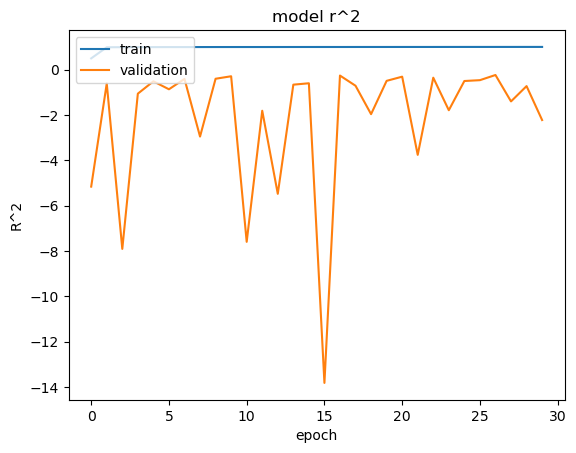

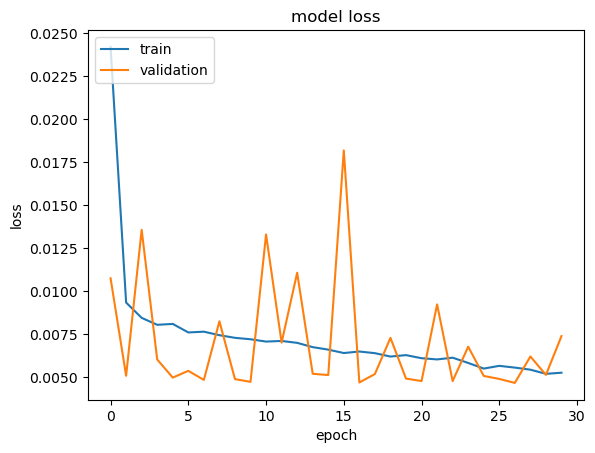

In [ ]:
import matplotlib.pyplot as plt

# summarize history for R^2
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# TEST
train,normalize = NormalizeMult(train)
pollution_test = train[:,0].reshape(len(train),1)

test_X, _ = create_dataset(train,TIME_STEPS)
_ , test_Y = create_dataset(pollution_test,TIME_STEPS)
print(test_X.shape,test_Y.shape)

(12, 2)
(35949, 50, 11) (35949, 1)


In [ ]:

# Prediction
scores_test = m.evaluate([test_X], test_Y, verbose=2)

1124/1124 - 9s - loss: 0.0064 - mae: 0.0064 - r2_keras: -1.3454e+00 - 9s/epoch - 8ms/step


In [ ]:
results = m.predict([test_X])

1124/1124 [==============================] - 9s 8ms/step


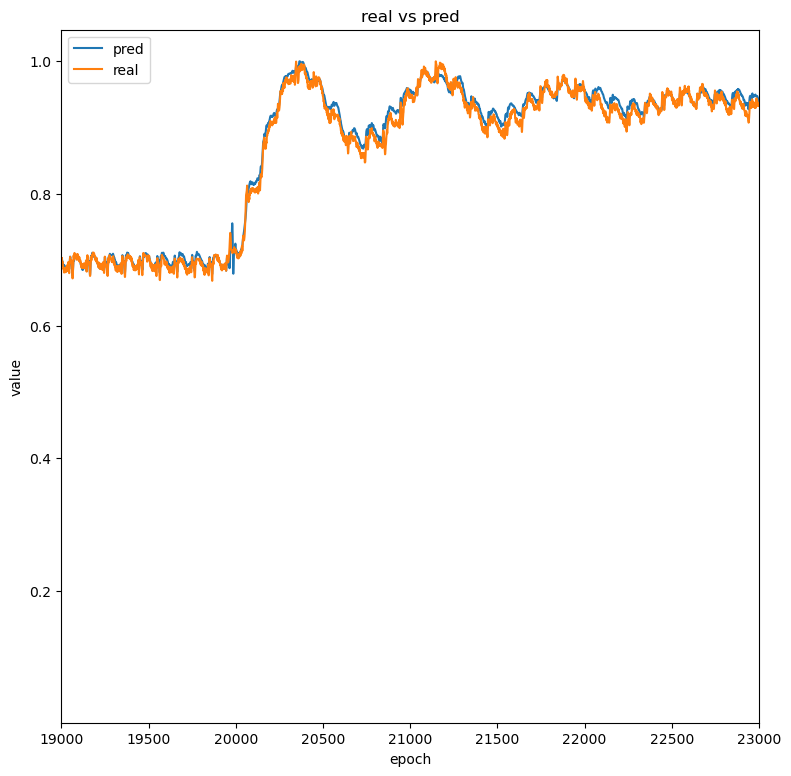

In [ ]:

fig_acc = plt.figure(figsize=(9, 9))
plt.plot(results[0:27000])
plt.plot(test_Y[0:27000])
plt.title('real vs pred')
plt.ylabel('value')
plt.xlabel('epoch')
plt.xlim((19000, 23000))
plt.legend(['pred', 'real'], loc='upper left')
plt.show()

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

print('以下是CNN_biLSTM_Attention误差')
print('R^2决定系数：',r2_score(test_Y[000:14000],results[00:14000]))
print('RMSE为：',np.sqrt(mean_squared_error(test_Y[2500:18000],results[2500:18000])))
print('MAPE为：',(abs(results[9000:15000] -test_Y[9000:15000])/ test_Y[9000:15000]).mean())

以下是CNN_biLSTM_Attention误差
R^2决定系数： 0.9779385664109004
RMSE为： 0.005917735257223756
MAPE为： 0.0070321039353948124


In [ ]:
test_new=[]
predict_new=[] 

for k in range(len(results)):
    if test_Y[k]!=0:
        test_new.append(test_Y[k])
        predict_new.append(results[k])

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.fabs((y_true - y_pred) / y_true))
mape = format(MAPE(test_new, predict_new), '.4f') 
mape

'0.0081'